<a href="https://colab.research.google.com/github/Tkht44/Vit_vs_CNN/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# トレーニングデータのインポート & チェック

In [54]:
# import needed file
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


In [55]:
# import data
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

# ハイパーパラメータの設定
batch_size = 100
epochs = 10

# 訓練データ
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# テストデータ
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)


In [56]:
print(trainset.data.shape)
(50000, 32, 32, 3)

# テスト用データセット：縦横32ピクセルのRGBの画像が10000枚
print(testset.data.shape)
(10000, 32, 32, 3)

# クラス一覧を確認する
print(trainset.classes)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# classesはよく利用するので別途保持しておく
classes = trainset.classes

(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 444, 274)
(444, 274, 3)


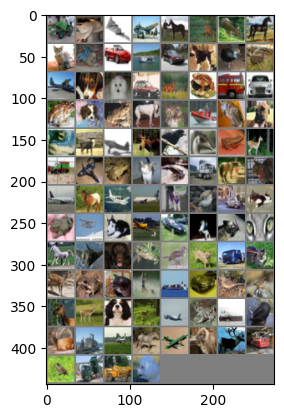

truck   cat airplane airplane


In [57]:
def imshow(img):
    # 非正規化する
    img = img / 2 + 0.5
    # torch.Tensor型からnumpy.ndarray型に変換する
    print(type(img)) # <class 'torch.Tensor'>
    npimg = img.numpy()
    print(type(npimg))
    # 形状を（RGB、縦、横）から（縦、横、RGB）に変換する
    print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    # 画像を表示する
    plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [58]:
# 別ファイルのimport
import cnn
import vit

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# パラメータの調整
cnn_net = cnn.Net(
    class_num=10,
    conv_size=[3,6,16],
    linear_size=[120,84]
)
vit_net = vit.Net(
    image_size=32, # height = width = image_size
    patch_size=4,
    n_classes=10,
    dim=256,
    depth=3,
    n_heads=4,
    mlp_dim=256,
)

cnn_net.to(device)
vit_net.to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()
# CNNオプティマイザの設定
optimizer_cnn = torch.optim.SGD(cnn_net.parameters(),lr = 0.001, momentum=0.9)
optimizer_vit = torch.optim.SGD(vit_net.parameters(),lr = 0.001, momentum=0.9)


cuda:0


In [60]:
print(cnn_net)
print(vit_net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)
Net(
  (patching): Patching(
    (net): Rearrange('b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=4, pw=4)
  )
  (linear_projection_of_flattened_patches): LinearProjection(
    (net): Linear(in_features=48, out_features=256, bias=True)
  )
  (embedding): Embedding()
  (transformer_encoder): TransformerEncoder(
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (multi_head_attention): MultiHeadAttention(
      (W_q): Linear(in_features=256, out_features=256, bias=True)
      (W_k): Linear(in_features=256, out_features=256, bias=True)
      (W_v): Linear(in_features=25

# ViTでの学習

In [62]:
# トレーニングする

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_vit.zero_grad()
        outputs = vit_net(inputs)
        loss = criterion(outputs, labels)

        # 誤差逆伝播
        loss.backward()
        optimizer_vit.step()
        # 損失と精度の計算
        train_loss += loss.item()/len(trainloader)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        train_acc += acc/len(trainloader)
        del inputs
        del outputs
        del loss
    vit_net.eval()
    with torch.no_grad():
            for data in testloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = vit_net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()/len(testloader)
                test_acc = (outputs.argmax(dim=1) == labels).float().mean()
                test_acc += test_acc/len(testloader)

    print(f'Epoch {epoch+1} : train acc. {train_acc:.2f} train loss {train_loss:.2f}')
    print(f'Epoch {epoch+1} : test acc. {test_acc:.2f} test loss {test_loss:.2f}')
print('Finished Training')

Epoch 1 : train acc. 0.20 train loss 2.14
Epoch 1 : test acc. 0.29 test loss 2.02
Epoch 2 : train acc. 0.30 train loss 1.94
Epoch 2 : test acc. 0.36 test loss 1.86
Epoch 3 : train acc. 0.34 train loss 1.83
Epoch 3 : test acc. 0.32 test loss 1.76
Epoch 4 : train acc. 0.38 train loss 1.73
Epoch 4 : test acc. 0.33 test loss 1.67
Epoch 5 : train acc. 0.41 train loss 1.65
Epoch 5 : test acc. 0.38 test loss 1.61
Epoch 6 : train acc. 0.44 train loss 1.58
Epoch 6 : test acc. 0.50 test loss 1.54
Epoch 7 : train acc. 0.45 train loss 1.52
Epoch 7 : test acc. 0.41 test loss 1.49
Epoch 8 : train acc. 0.47 train loss 1.47
Epoch 8 : test acc. 0.47 test loss 1.45
Epoch 9 : train acc. 0.49 train loss 1.43
Epoch 9 : test acc. 0.54 test loss 1.43
Epoch 10 : train acc. 0.50 train loss 1.40
Epoch 10 : test acc. 0.56 test loss 1.39
Finished Training


# CNNでの学習

In [63]:
# トレーニングする
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_cnn.zero_grad()
        outputs = cnn_net(inputs)
        # 誤差逆伝播
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        # 損失と精度の計算
        train_loss += loss.item()/len(trainloader)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        train_acc += acc/len(trainloader)
        del inputs
        del outputs
        del loss
    cnn_net.eval()
    with torch.no_grad():
            for data in testloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = cnn_net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()/len(testloader)
                test_acc = (outputs.argmax(dim=1) == labels).float().mean()
                test_acc += test_acc/len(testloader)

    print(f'Epoch {epoch+1} : train acc. {train_acc:.2f} train loss {train_loss:.2f}')
    print(f'Epoch {epoch+1} : test acc. {test_acc:.2f} test loss {test_loss:.2f}')
print('Finished Training')

Epoch 1 : train acc. 0.11 train loss 2.30
Epoch 1 : test acc. 0.09 test loss 2.30
Epoch 2 : train acc. 0.16 train loss 2.29
Epoch 2 : test acc. 0.18 test loss 2.26
Epoch 3 : train acc. 0.22 train loss 2.15
Epoch 3 : test acc. 0.25 test loss 2.04
Epoch 4 : train acc. 0.28 train loss 1.97
Epoch 4 : test acc. 0.31 test loss 1.89
Epoch 5 : train acc. 0.33 train loss 1.82
Epoch 5 : test acc. 0.33 test loss 1.73
Epoch 6 : train acc. 0.38 train loss 1.69
Epoch 6 : test acc. 0.38 test loss 1.64
Epoch 7 : train acc. 0.40 train loss 1.62
Epoch 7 : test acc. 0.33 test loss 1.58
Epoch 8 : train acc. 0.43 train loss 1.56
Epoch 8 : test acc. 0.43 test loss 1.52
Epoch 9 : train acc. 0.45 train loss 1.51
Epoch 9 : test acc. 0.50 test loss 1.49
Epoch 10 : train acc. 0.46 train loss 1.47
Epoch 10 : test acc. 0.56 test loss 1.46
Finished Training


In [64]:
cnn_Path = './cnn_cifar_net.pth'
vit_Path = './vit_cifar_net.pth'
torch.save(cnn_net.state_dict(),cnn_Path)
torch.save(vit_net.state_dict(), vit_Path)

# 比較